In [1]:
import pandas as pd # libraries 
import numpy as np 

In [2]:
df = pd.read_excel('Online Retail.xlsx' , engine='openpyxl')

In [3]:
df.head() # first few rows of the data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Drop missing Customer IDs
df = df[pd.notnull(df['CustomerID'])]

In [5]:
# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [6]:
# Focus on only UK customers (optional for simplifying analysis)
df = df[df['Country'] == 'United Kingdom']

In [7]:
# Show data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int64         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [8]:
  # Creating Recency, Frequency and Monetary features per customer ..... Feature Enginering(RFM)

In [9]:
# Define reference date (e.g., last date in data)
ref_date = df['InvoiceDate'].max()

In [10]:
# Creating a Total price 
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [11]:
# Grouping to create RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': lambda x: (df[df['CustomerID'] == x.name]['Quantity'] * 
                             df[df['CustomerID'] == x.name]['UnitPrice']).sum()  # Monetary
}).reset_index()

In [12]:
# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [13]:
# Show sample
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,0.0
1,12747.0,1,11,0.0
2,12748.0,0,210,0.0
3,12749.0,3,5,0.0
4,12820.0,2,4,0.0


In [14]:
# Normalizing RFM features before clustering 

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
rfmn_normalized = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [17]:
 # Determing the  Optimal Clustering using (Elbow Method )

In [18]:
from sklearn.cluster import KMeans

In [19]:
# Elbow method
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfmn_normalized)
    sse[k] = kmeans.inertia_

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

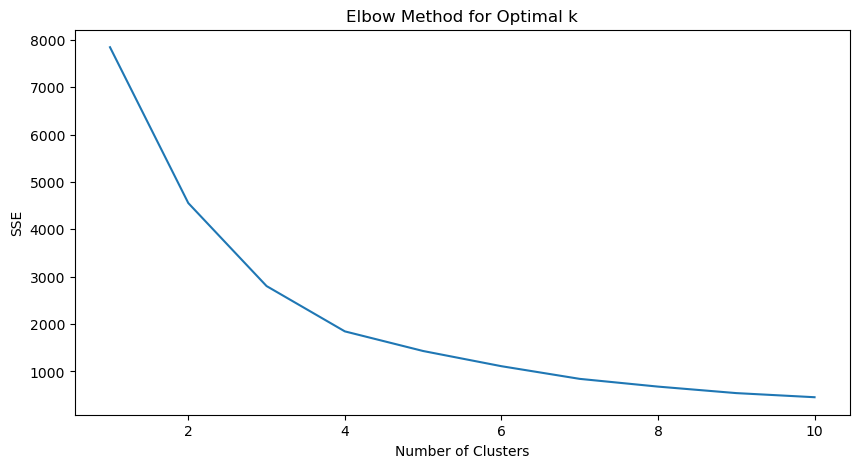

In [21]:
# PLoting
plt.figure(figsize=(10, 5))
sns.lineplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [22]:
# Clustering the customer into segmentation using K_Means

In [23]:
# Apply KMeans with optimal k 
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfmn_normalized)

# Preview clusters
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,325,1,0.0,0
1,12747.0,1,11,0.0,1
2,12748.0,0,210,0.0,2
3,12749.0,3,5,0.0,1
4,12820.0,2,4,0.0,1


In [24]:
# Cluster Summary
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

cluster_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,245.582474,1.569072,0.0,970
1,42.804539,3.587482,0.0,2732
2,1.000000,116.833333,0.0,6
3,11.206573,21.713615,0.0,213


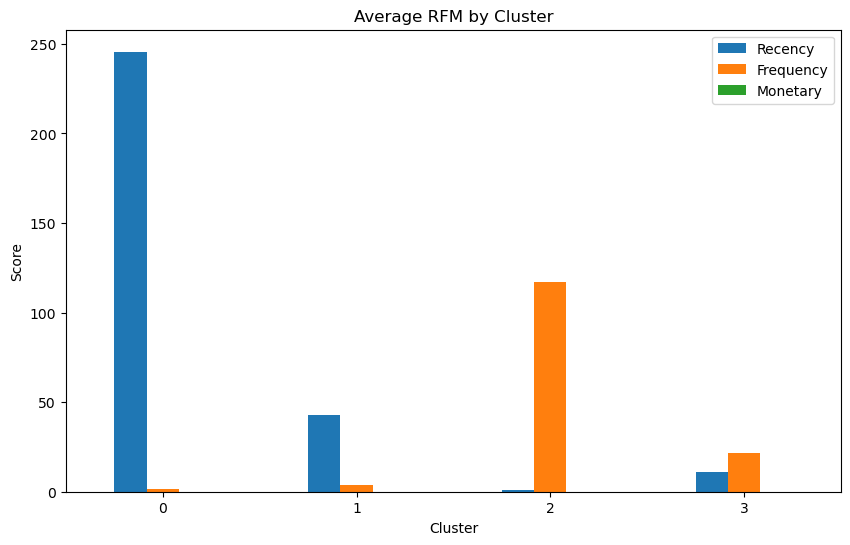

In [25]:
# Bar plot of RFM by Cluster
cluster_summary[['Recency', 'Frequency', 'Monetary']].plot(kind='bar', figsize=(10, 6))
plt.title('Average RFM by Cluster')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

In [31]:
# Save the final Rfm dataframe with sgement label to a csv file
rfm.to_csv('rfm_with_segments.csv', index=False)
print('File saved successfully as rfm_with_segments.csv')

File saved successfully as rfm_with_segments.csv
